# Plotting raw data
This notebook focuses on plotting raw measurements (VOD calculation and plotting is covered in the next one)

In [1]:
import gnssvod as gv
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates

The first step is to load all files of the merged data that were saved as a NetCDF.

We can read them as a series of xarray datasets.

In [2]:
ds = xr.open_mfdataset('data_RINEX2.11/Dav_paired/*.nc',combine='nested',concat_dim='Epoch')
ds

<xarray.Dataset> Size: 9MB
Dimensions:    (Station: 2, Epoch: 1441, SV: 77)
Coordinates:
  * Station    (Station) <U9 72B 'Dav1_Grnd' 'Dav2_Twr'
  * SV         (SV) <U3 924B 'C06' 'C07' 'C09' 'C10' ... 'R23' 'S23' 'S27' 'S36'
  * Epoch      (Epoch) datetime64[ns] 12kB 2021-04-28T21:07:00 ... 2021-04-29...
Data variables:
    S1         (Station, Epoch, SV) float64 2MB dask.array<chunksize=(2, 692, 55), meta=np.ndarray>
    S2         (Station, Epoch, SV) float64 2MB dask.array<chunksize=(2, 692, 55), meta=np.ndarray>
    S7         (Station, Epoch, SV) float64 2MB dask.array<chunksize=(2, 692, 55), meta=np.ndarray>
    Azimuth    (Station, Epoch, SV) float64 2MB dask.array<chunksize=(2, 692, 55), meta=np.ndarray>
    Elevation  (Station, Epoch, SV) float64 2MB dask.array<chunksize=(2, 692, 55), meta=np.ndarray>

Here we will convert the xarray.DataSet to a pandas.DataFrame for further processing

In [3]:
df = ds.to_dataframe().dropna(how='all').reorder_levels(["Station","Epoch","SV"]).sort_index()
df

S1    S2    S7  Azimuth  Elevation
Station   Epoch               SV                                       
Dav1_Grnd 2021-04-28 21:07:00 C06   NaN   NaN  25.0     36.6       10.1
                              C09  35.0  35.0  30.0     49.0       32.7
                              C11  33.0  33.0  30.5    177.2       35.1
                              C14  36.3  36.3  35.2    -96.4       76.8
                              C16  30.7  30.7  30.8     38.3       15.2
...                                 ...   ...   ...      ...        ...
Dav2_Twr  2021-04-29 03:07:00 R16  46.4  35.7   NaN   -173.5       68.9
                              R23  43.0   NaN   NaN      NaN        NaN
                              S23  45.0   NaN   NaN      NaN        NaN
                              S27  29.5   NaN   NaN      NaN        NaN
                              S36  44.0   NaN   NaN      NaN        NaN

[89349 rows x 5 columns]

## Hemispheric plot of raw measurements
### Subsetting the data
For plotting, it will be useful to know how to easily subset data. As the dataframe contains a MultiIndex, we use the `.xs` function to subset it. For instance, to get all data from the Galileo satellite #3 at the ground station:

In [4]:
df.xs('E03',level='SV').xs('Dav1_Grnd',level='Station')

,S1,S2,S7,Azimuth,Elevation
Epoch,,,,,
2021-04-28 21:07:00,NaN,NaN,26.5,-141.2,25.9
2021-04-28 21:07:15,NaN,NaN,27.4,-141.2,26.0
2021-04-28 21:07:30,NaN,NaN,28.6,-141.1,26.1
2021-04-28 21:07:45,25.4,NaN,30.2,-141.1,26.2
2021-04-28 21:08:00,27.0,NaN,31.0,-141.0,26.3
...,...,...,...,...,...
2021-04-29 03:06:00,39.0,NaN,24.5,110.9,36.3
2021-04-29 03:06:15,39.0,NaN,20.9,111.0,36.3
2021-04-29 03:06:30,39.0,NaN,22.2,111.0,36.2


### Plotting observation points in polar coordinates
#### Single satellite, single site

Text(0.5, 1.0, 'Dav1_Grnd')

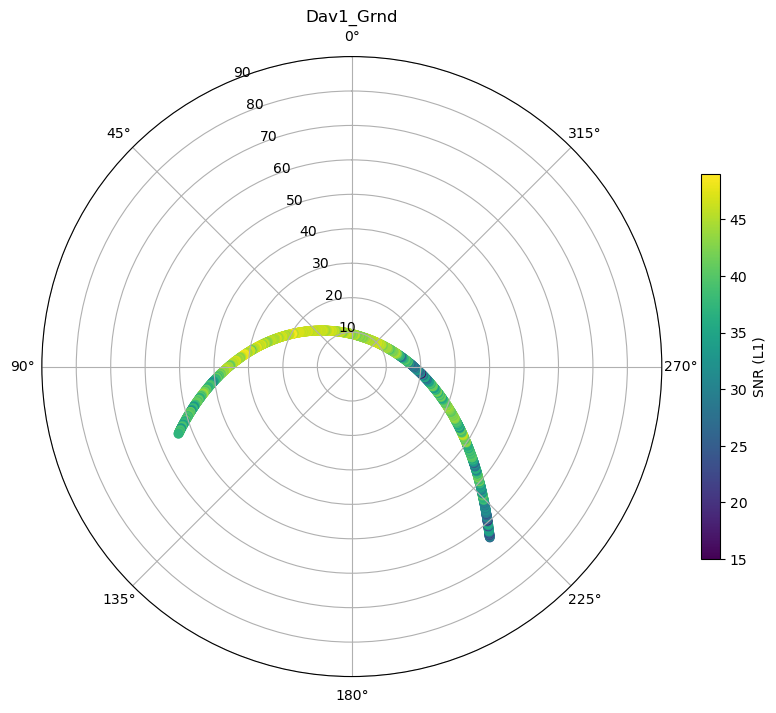

In [5]:
mySV = 'E03'
mystation_name = 'Dav1_Grnd'
# initialize figure with polar axes
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection='polar'))
# subset the dataset
subdf = df.xs(mySV,level='SV').xs(mystation_name,level='Station')

# polar plots need a radius and theta direction in radians
radius = 90-subdf.Elevation
theta = np.deg2rad(subdf.Azimuth)

# plot each measurement and color by signal to noise ratio
hs = ax.scatter(theta,radius,c=subdf.S1)
ax.set_rlim([0,90])
ax.set_theta_zero_location("N")
plt.colorbar(hs, shrink=.5, label='SNR (L1)')
plt.title(mystation_name)

#### Single satellite, all sites

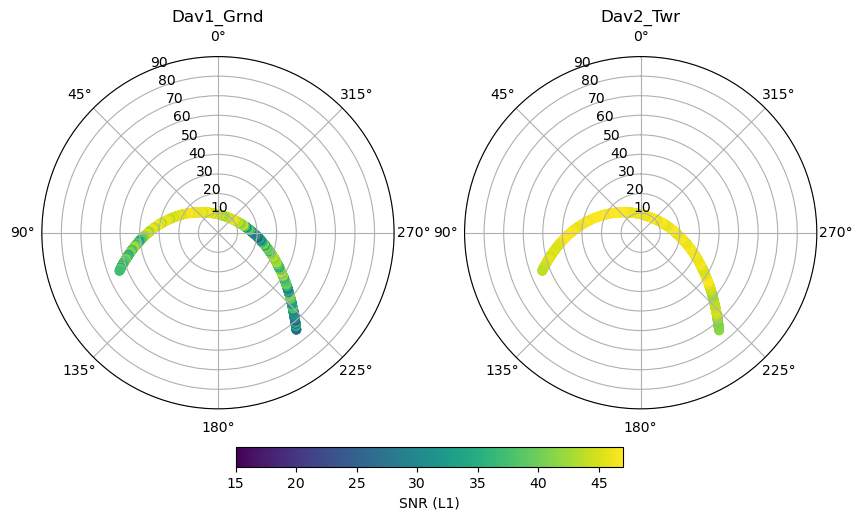

In [6]:
mySV = 'E03'
# get all sites as list
station_names = df.index.get_level_values('Station').unique()
# ensure we use the same color limits in all plots
clim = [15,47]
# initialize figure with polar axes
fig, ax = plt.subplots(1,len(station_names),figsize=(10,10),subplot_kw=dict(projection='polar'))
for i, iname in enumerate(station_names):
    # subset the dataset
    subdf = df.xs(mySV,level='SV').xs(iname,level='Station')
    # polar plots need a radius and theta direction in radians
    radius = 90-subdf.Elevation
    theta = np.deg2rad(subdf.Azimuth)
    # plot each measurement and color by signal to noise ratio
    hs = ax[i].scatter(theta,radius,c=subdf.S1)
    hs.set_clim(clim)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_title(iname)

plt.colorbar(hs, ax=ax, location='bottom', shrink=.5, pad=0.05, label='SNR (L1)')

#### All satellites, all sites

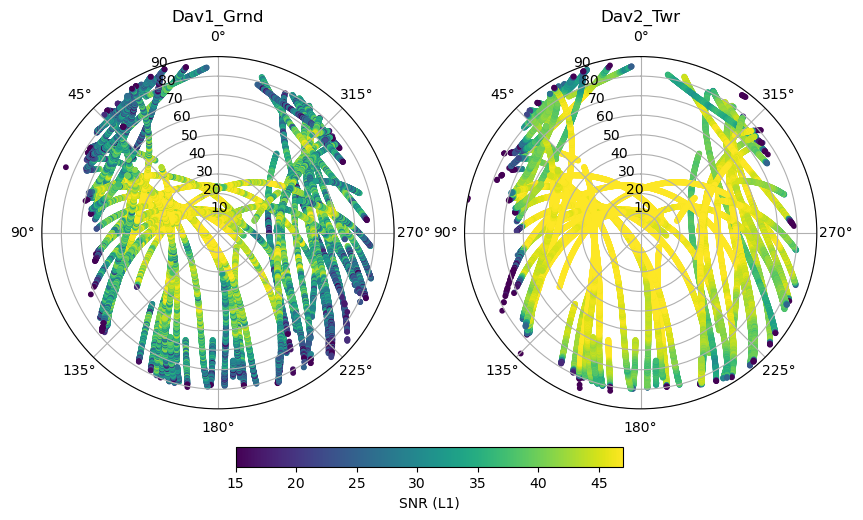

In [7]:
# get all sites as list
station_names = df.index.get_level_values('Station').unique()
# ensure we use the same color limits in all plots
clim = [15,47]
# initialize figure with polar axes
fig, ax = plt.subplots(1,len(station_names),figsize=(10,10),subplot_kw=dict(projection='polar'))
for i, iname in enumerate(station_names):
    # subset the dataset
    subdf = df.xs(iname,level='Station')
    # polar plots need a radius and theta direction in radians
    radius = 90-subdf.Elevation
    theta = np.deg2rad(subdf.Azimuth)
    # plot each measurement and color by signal to noise ratio
    hs = ax[i].scatter(theta,radius,c=subdf.S1,s=10)
    hs.set_clim(clim)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_title(iname)

plt.colorbar(hs, ax=ax, location='bottom', shrink=.5, pad=0.05, label='SNR (L1)')

As expected, signal to noise is larger at the clear-sky (Dav2_Twr) site. We also see that SNR increases as a function of elevation. This mainly occurs because the GNSS antenna gain is strongest in the zenith direction.

We also see that no measurements can be found towards the North of the stations, this is because no GNSS satellites go over this area of the sky. 

Finally, to the West, measurements are missing below elevations of about 20°. This is because the surrounding terrain and the mountains are cutting off the line of sight to the satellite.

### Plotting observation points as time series

Text(0.5, 1.0, 'E03')

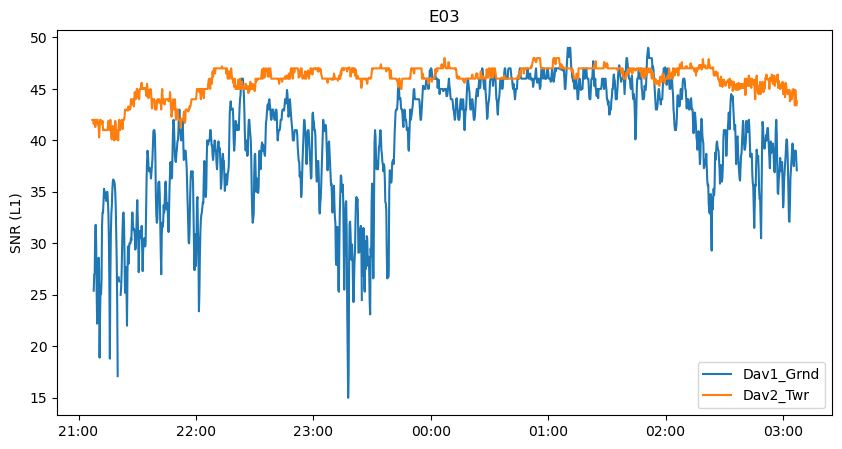

In [8]:
mySV = 'E03'
# get all sites as list
station_names = df.index.get_level_values('Station').unique()

fig, ax = plt.subplots(1,figsize=(10,5))
for i, iname in enumerate(station_names):
    # subset the dataset
    subdf = df.xs(iname,level='Station').xs(mySV,level='SV')
    # plot each measurement and color by signal to noise ratio
    hs = ax.plot(subdf.index.get_level_values('Epoch'),subdf.S1,label=iname)
    
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('SNR (L1)')
ax.legend()
plt.title(mySV)

Here we see several interesting features. In the beginning, the SNR of the clear-sky antenna (Dav2_Twr) increases over time as the satellite gets closer to the zenith, then starts to decrease after passing zenith.

We also observe oscillations of the clear-sky signal. These are likely the result of ground multipath reflections. The ground reflected signal reaches the receiver with a delay, causing an either constructive (signal enhancement) or destructive (signal attenuation) interference, in alternance as the satellite rises in the sky.

Finally, we see that the signal is severely attenuated at the subcanopy site, as the satellite is obscured by more or less dense parts of the canopy. Around 00:00-02:00 the satellite likely was moving through a gap in the canopy and the signal strength is more or less the same at the two receivers.

## Geostationary satellites
Some of the logged satellites are geostationary (meaning they stay in the same spot in the sky) and have an "S" as prefix. These are satellites of the regional Satellite-based Augmentation Systems (SBAS), here the European Geostationary Navigation Overlay Service (EGNOS). These satellites broadcast correction information calculated in real time, which improves positioning (if your GNSS receiver has the ability to receive it).

As they have a fixed position in the sky, they do not sample the whole canopy. As a result, their signals are much more constant over time.

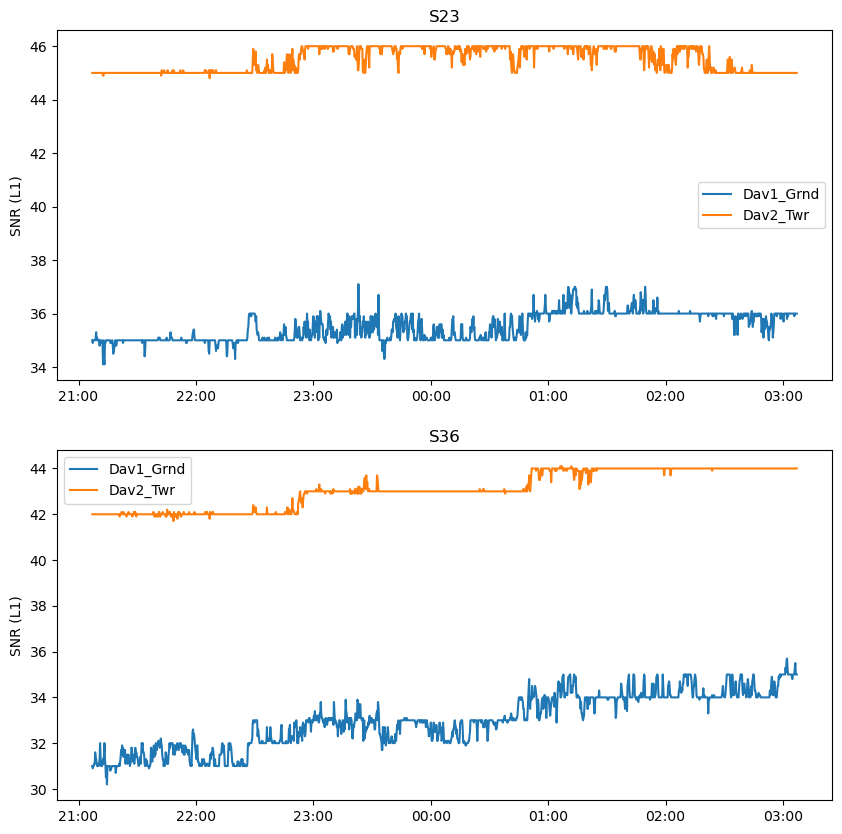

In [9]:
mySV = ['S23','S36']
# get all sites as list
station_names = df.index.get_level_values('Station').unique()

fig, ax = plt.subplots(len(mySV),figsize=(10,10))
for isv, svname in enumerate(mySV):
    for i, iname in enumerate(station_names):
        # subset the dataset
        subdf = df.xs(iname,level='Station').xs(svname,level='SV')
        # plot each measurement and color by signal to noise ratio
        hs = ax[isv].plot(subdf.index.get_level_values('Epoch'),subdf.S1,label=iname)
        
    myFmt = mdates.DateFormatter('%H:%M')
    ax[isv].xaxis.set_major_formatter(myFmt)
    ax[isv].set_ylabel('SNR (L1)')
    ax[isv].legend()
    ax[isv].set_title(svname)

Those measurements can be useful to diagnose other possible effects on SNR. For instance, the density of the atmosphere has an effect on SNR which can change over the day and will influence both stations similarly. The temperature of the sensing equipment (receiver, cables, antenna) can also vary over the day and have a small influence on SNR. 

The plateaus occurs because the SNR is encoded as an integer on the Reach M2 receiver. We are logging data every second, but we averaged to 15 seconds during preprocessing, explaing why we also have intermediate values.

Text(0.5, 1.0, 'S27')

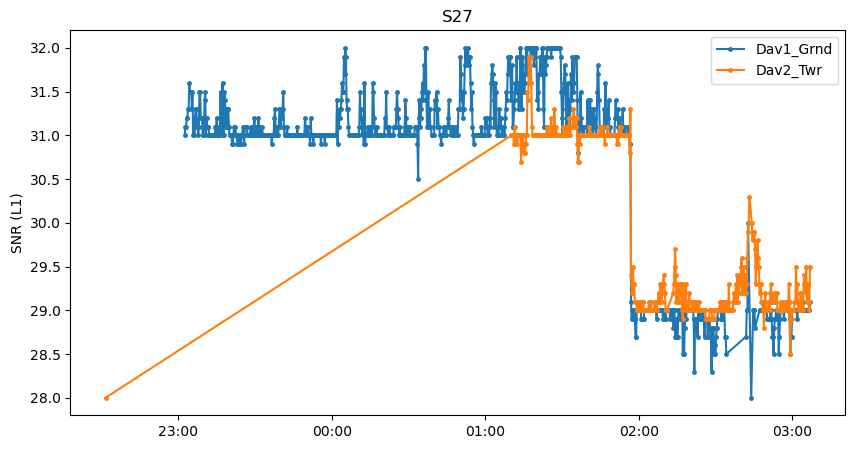

In [10]:
mySV = 'S27'
# get all sites as list
station_names = df.index.get_level_values('Station').unique()

fig, ax = plt.subplots(1,figsize=(10,5))
for i, iname in enumerate(station_names):
    # subset the dataset
    subdf = df.xs(iname,level='Station').xs(mySV,level='SV')
    # plot each measurement and color by signal to noise ratio
    hs = ax.plot(subdf.index.get_level_values('Epoch'),subdf.S1,label=iname,marker='.',markersize=5)
    
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('SNR (L1)')
ax.legend()
plt.title(mySV)

For this geostationary satellite, there is an outlier at about 22:30 for Dav2_Twr, causing a rather awkward time series. 

If a satellite is barely visible or has poor health, the receiver may lose track of the signal for some amount of time (a loss of signal tracking is seen for Dav1_Grnd around 02:30 for instance). 

Since both receivers record similar signal strength, it is most likely that the geostationary satellite appears in a gap in the canopy and the subcanopy receiver has a clear line of sight as well.

We also see a significant jump at around 01:50. This happens if the transmit power of the satellite is changed (for any power management reason). Such jumps also occur with normal (non-geostationary) satellites but may be less obvious to detect. Because such jumps can occur anytime and on any satellite, it is always recommended to calculate the signal attenuation caused by the canopy (i.e. the difference between the two sensors) at the level of instantaneous observations. If we took here the average of Dav1_Grnd and compared it to the average of Dav2_Twr, Dav1_Grnd would have higher signal strength, but only because Dav2_Twr did not take as many measurements when 'S27' was transmitting at a higher power. In summary, calculate the difference first, then average.

## Calculating and plotting hemispheric averages
Note, here because we only use 6 hours worth of data, plotting individual measurements as we did above is still possible. However, when working with larger datasets, this quickly becomes impractical. `gnssvod` offers a solution to calculate statistics (like an average) over a hemispheric grid.
### Hemispheric grid objects
The {class}`Hemi <gnssvod.Hemi>` class is a convenience class of `gnssvod` for creating, using, and plotting hemispheric grid objects.

They are constructed by specifying the desired angular resolution of cells in degrees. The smaller the angular resolution, the finer the grid.

In [11]:
hemi = gv.hemibuild(4)
hemi

#### Hemi object structure

`Hemi` objects expose a small set of attributes describing the grid geometry,
as well as helper methods to work with hemispheric binning.

**Attributes**

- **`Hemi.angular_resolution`**  
  Angular diameter of the zenith cell (degrees).

- **`Hemi.ncells`**  
  Total number of grid cells in the hemisphere.

- **`Hemi.grid`**  
  `pandas.DataFrame` describing cell geometry (centers and edges).

**Methods**

- **`Hemi.patches()`**  
  Returns a `pandas.Series` of matplotlib patches representing grid cells,
  typically used for hemispheric plotting.

- **`Hemi.add_CellID()`**  
  Assigns hemispheric CellIDs to an existing dataframe of GNSS observations,
  enabling spatial binning and statistics.

In [12]:
hemi.grid

,azi,ele,azimin,azimax,elemin,elemax
CellID,,,,,,
0,0.000000,90.0,0.000000,360.000000,88.0,90.0
1,22.500000,86.0,0.000000,45.000000,84.0,88.0
2,67.500000,86.0,45.000000,90.000000,84.0,88.0
3,112.500000,86.0,90.000000,135.000000,84.0,88.0
4,157.500000,86.0,135.000000,180.000000,84.0,88.0
...,...,...,...,...,...,...
1523,345.789474,6.0,344.210526,347.368421,4.0,8.0
1524,348.947368,6.0,347.368421,350.526316,4.0,8.0
1525,352.105263,6.0,350.526316,353.684211,4.0,8.0


To plot the grid, we first retrieve the patches:

In [13]:
# get patches
patches = hemi.patches() 
patches

CellID
0       Rectangle(xy=(0, 0), width=6.28319, height=2, ...
1       Rectangle(xy=(0, 2), width=0.785398, height=4,...
2       Rectangle(xy=(0.785398, 2), width=0.785398, he...
3       Rectangle(xy=(1.5708, 2), width=0.785398, heig...
4       Rectangle(xy=(2.35619, 2), width=0.785398, hei...
                              ...                        
1523    Rectangle(xy=(6.00761, 82), width=0.0551157, h...
1524    Rectangle(xy=(6.06272, 82), width=0.0551157, h...
1525    Rectangle(xy=(6.11784, 82), width=0.0551157, h...
1526    Rectangle(xy=(6.17295, 82), width=0.0551157, h...
1527    Rectangle(xy=(6.22807, 82), width=0.0551157, h...
Name: Patches, Length: 1528, dtype: object

Creating the patches can take time, especially if there are many. With an angular resolution of 6° and 693 patches, this is still quite fast, but at 0.1°, it will take a lot of time. This is why patches are only calculated if the method `.patches()` is called by the user and are otherwise not calculated by default when calling `hemibuild`

The patches can then be easily plotted as follows:

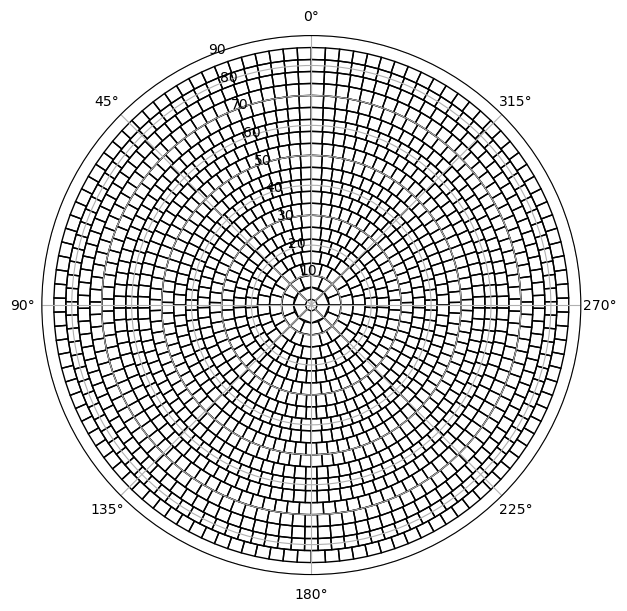

In [14]:
fig, ax = plt.subplots(figsize=(7,7),subplot_kw=dict(projection='polar'))
pc = PatchCollection(patches.values,facecolor='none',linewidth=1)
#ax.bar(0, 1).remove() # bar hack to force curved patch edges, activate this if the patches look square and not curved
ax.add_collection(pc)
ax.set_rlim([0,90])
ax.set_theta_zero_location("N")

### Assigning measurements to grid cells

The {meth}`Hemi.add_CellID <gnssvod.Hemi.add_CellID>` assigns a CellID to an existing dataframe of GNSS measurements.

```python
df = hemi.add_CellID(
    df,
    aziname="Azimuth",
    elename="Elevation",
    idname="CellID",
    drop=True,
)
```

By default, it will assume that the dataframe `df` contains columns named Azimuth and Elevation, and that the CellID should be added to a new column named `CellID`. All these defaults can be easily overriden by manipulating the arguments. `drop=True` means that measurements that do not fall within in any cell are dropped off (discarded from the df). This can affect a substantial number of observations if an elevation cutoff larger than zero was specified when building the grid with {py:func}`hemibuild <gnssvod.hemibuild>`.

In [15]:
newdf = hemi.add_CellID(df)
newdf

S1    S2    S7  Azimuth  Elevation  \
Station   Epoch               SV                                          
Dav1_Grnd 2021-04-28 21:07:00 C06   NaN   NaN  25.0     36.6       10.1   
                              C09  35.0  35.0  30.0     49.0       32.7   
                              C11  33.0  33.0  30.5    177.2       35.1   
                              C14  36.3  36.3  35.2    -96.4       76.8   
                              C16  30.7  30.7  30.8     38.3       15.2   
...                                 ...   ...   ...      ...        ...   
Dav2_Twr  2021-04-29 03:07:00 R05  49.4  39.0   NaN    123.8       40.1   
                              R07  46.5  37.0   NaN    -44.0       20.7   
                              R09  42.4  39.3   NaN   -154.1       18.9   
                              R15  50.5  40.6   NaN     40.7       45.7   
                              R16  46.4  35.7   NaN   -173.5       68.9   

                                   CellID  
Station   Epoch               SV           
Dav1_Grnd 2021-04-28 21:07:00 C06    1312  
                              C09     690  
                              C11     724  
                              C14      42  
                              C16    1201  
...                                   ...  
Dav2_Twr  2021-04-29 03:07:00 R05     532  
                              R07    1068  
                              R09    1143  
                              R15     432  
                              R16     101  

[80816 rows x 6 columns]

It now becomes relatively easy to calculate any sort of statistics per grid cell using the base pandas functions.

In [16]:
hemi_average = newdf.groupby(['CellID','Station']).mean()
hemi_average

S1         S2    S7     Azimuth  Elevation
CellID Station                                                     
1      Dav1_Grnd  47.853333  43.027273  39.0    4.746667  84.620000
       Dav2_Twr   48.353333  43.581818  41.0    4.746667  84.620000
3      Dav1_Grnd  47.677419  41.145161   NaN  114.351613  84.716129
       Dav2_Twr   48.361290  43.958065   NaN  114.351613  84.722581
4      Dav1_Grnd  47.925000  42.715000   NaN  146.860000  84.560000
...                     ...        ...   ...         ...        ...
1522   Dav1_Grnd  35.250000        NaN   NaN  -15.933333   7.750000
       Dav2_Twr   44.333333  35.150000   NaN  -15.933333   7.750000
1523   Dav1_Grnd  30.300000        NaN   NaN  -15.700000   7.400000
       Dav2_Twr   44.133333  35.550000   NaN  -15.666667   7.300000
1524   Dav2_Twr   36.300000        NaN   NaN   -9.700000   8.000000

[1779 rows x 5 columns]

We can now plot this data in grid form. Here we look at the mean signal to noise ratio (SNR) at each site.

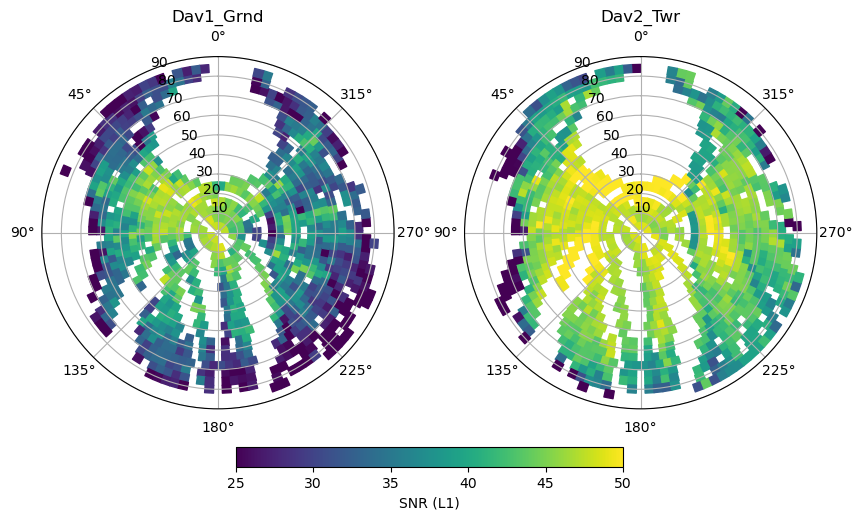

In [17]:
fig, ax = plt.subplots(1,2,figsize=(10,10),subplot_kw=dict(projection='polar'))

station_names = df.index.get_level_values('Station').unique()
for i, iname in enumerate(station_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    ipatches = pd.concat([patches,hemi_average.xs(iname, level='Station')],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches.S1,edgecolor='face', linewidth=1)
    pc.set_clim([25,50])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='SNR (L1)')
plt.savefig('figures/illustration_snr.png',facecolor='white', transparent=False,bbox_inches='tight')

We can also look at the number of observations by calculating another statistic

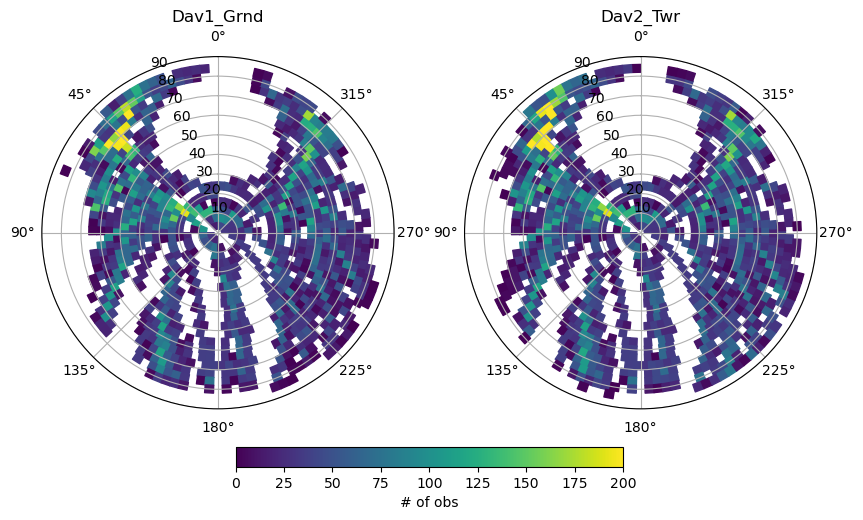

In [18]:
hemi_count = newdf.groupby(['CellID','Station']).count()
hemi_count

fig, ax = plt.subplots(1,2,figsize=(10,10),subplot_kw=dict(projection='polar'))

station_names = df.index.get_level_values('Station').unique()
for i, iname in enumerate(station_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    ipatches = pd.concat([patches,hemi_count.xs(iname, level='Station')],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches.S1,edgecolor='face', linewidth=1)
    pc.set_clim([0,200])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='# of obs')

In the next notebook, we illustrate how to calculate and plot GNSS-VOD.